In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/MRA

/content/drive/My Drive/MRA


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# sns.set(style="whitegrid")
import warnings
from sklearn.svm import SVC, NuSVC
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors  import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from scipy import stats
from scipy.stats import uniform, randint
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score
# from tflearn.data_utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
from numpy import interp
from scipy import *
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from keras.utils import to_categorical

In [ ]:
# read the dataframe
data = pd.read_csv('diabetes.csv')
data.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

### Necessary Functions

In [ ]:
Renamed_feature = ['F'+str(i+1) for i in range(8)]  # Renaming columns F1 to F8
all_clf_res = []
random_initializer = 100
n_dots = 50

# Function to plot pairwise relationships between variables
def pair_plot(data):
    sns.pairplot(data=data, height=3, hue='Outcome', diag_kind='kde')
    plt.suptitle("Pairplot of all features")
    plt.show()

# Function to plot Gaussian distribution and box plot
def Box_Gaussian(data):
    fig, axes = plt.subplots(2, 4, figsize=(15, 6))
    fig.suptitle("Box Gaussian plot of all features")

    n_scaler = preprocessing.StandardScaler()
    temp_Data = n_scaler.fit_transform(data)

    for i, ax in enumerate(axes.flatten()):
        Data = temp_Data[:, i]
        sns.kdeplot(Data, shade=True, color='red', alpha=0.3, ax=ax)
        sns.boxplot(Data, saturation=0.9, color="green", ax=ax)
        ax.invert_yaxis()
        ax.set_xticklabels([])
        ax.set_ylim(-0.5, 0.65)
    plt.tight_layout()

# Function to plot a confusion matrix (correlation heatmap)
def plot_confusionMatrix(data):
    plt.figure(figsize=(10, 8))
    sns.heatmap(data.corr(), vmax=1.0, vmin=0.0, annot=True, linewidths=0.01, linecolor="black")
    plt.title("Confusion Matrix of all features")
    plt.ylim(plt.ylim()[0] + 0.5, plt.ylim()[1] - 0.5)  # Fix for ylim issue
    plt.show()

In [ ]:
# Plot univariate distribution of each feature
def dist_Plot(data):
    fig, ax = plt.subplots(2, 4, figsize=(12, 5))
    fig.suptitle("Gaussian Distribution of all features")
    for i in range(8):
        sns.distplot(data[f'F{i+1}'], bins=10, ax=ax[i//4, i%4])
    fig.tight_layout()

# Plot violin plots for each feature
def plot_violinplot(data):
    fig, ax = plt.subplots(2, 4, figsize=(12, 6))
    fig.suptitle("Violin plot of all features")
    for i in range(8):
        sns.violinplot(x=data.Outcome, y=data[f'F{i+1}'], ax=ax[i//4, i%4])
    fig.tight_layout()

# Manual outlier rejection based on extreme values
def Manual(data):
    reject_extremes = {
        'F1': 1, 'F2': 5, 'F3': 1, 'F4': 2, 'F5': 25, 'F6': 4, 'F7': 20, 'F8': 20
    }
    for feature, count in reject_extremes.items():
        for _ in range(count):
            data = data[data[feature] != data[feature].max()]
    return data

# Outlier rejection based on Interquartile Range (IQR) and replacement with mean
def IQR_Mean(data):
    for feature in Renamed_feature:
        Q1, Q3 = data[feature].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        mean = data[feature].mean()
        LW, UW = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        data[feature] = data[feature].apply(lambda x: mean if x < LW or x > UW else x)
    return data


In [ ]:
# Outlier rejection with respect to median
def IQR_Median(data):
    for i in range(8):
        x = data[Renamed_feature[i]]
        Q1, Q3 = x.quantile([0.25, 0.75])
        IQR = Q3 - Q1
        median = x.median()
        LW, UW = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        x[(x < LW) | (x > UW)] = median
        data[Renamed_feature[i]] = x
    return data

# Outlier rejection within 1.5 * IQR
def IQR(data):
    for i in range(8):
        Q1, Q3 = data[Renamed_feature[i]].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        LW, UW = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        data = data[(data[Renamed_feature[i]] < UW) & (data[Renamed_feature[i]] > LW)]
    return data

# Combined outlier rejection based on user input
def outlier_Rejection(data, iqr_Mean=False, iqr_Median=False, iqr=False, manual=False):
    if iqr_Mean: data = IQR_Mean(data)
    if iqr_Median: data = IQR_Median(data)
    if iqr: data = IQR(data)
    if manual: data = Manual(data)
    return data

# Plotting function based on user selection
def data_plot(data, Pair_plot=False, Dist_Plot=False, Plot_violinplot=False, Plot_confusionMatrix=False, box_Gaussian=False):
    if Pair_plot: pair_plot(data)
    if Dist_Plot: dist_Plot(data)
    if Plot_violinplot: plot_violinplot(data)
    if Plot_confusionMatrix: plot_confusionMatrix(data)
    if box_Gaussian: Box_Gaussian(data)

# Replace zeros in fields based on the mean per target
def replace_zero(data, field, target):
    mean_by_target = data.loc[data[field] != 0, [field, target]].groupby(target).mean()
    data.loc[(data[field] == 0) & (data[target] == 0), field] = mean_by_target.iloc[0][0]
    data.loc[(data[field] == 0) & (data[target] == 1), field] = mean_by_target.iloc[1][0]

# Metrics calculation with ROC curve and confusion matrix
def metrics(y_true, y_pred, probas_):
    fpr, tpr, _ = roc_curve(y_true, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print(classification_report(y_true, y_pred))
    print("AUC: {}".format(roc_auc))
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn, fp, fn, tp, roc_auc, fpr, tpr

# Average ROC curve plotting
def average_ROC(mean_fpr, tprs, aucs, TP, TN, FP, FN):
    sen = np.sum(TP) / (np.sum(TP) + np.sum(FN))
    spe = np.sum(TN) / (np.sum(TN) + np.sum(FP))
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc, std_auc = np.mean(aucs), np.std(aucs)

    plt.plot(mean_fpr, mean_tpr, color='blue', lw=2, alpha=.8,
             label=f'Avg. ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})')
    plt.scatter(1-spe, sen, s=80, c='r', marker='x')
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0),
                     mean_tpr + np.std(tprs, axis=0), color='darkgray', alpha=0.5)
    plt.xlabel('False Positive Rate'), plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right"), plt.show()

# Plot current ROC curve
def plot_Current_ROC(fpr,tpr,iterator,roc_auc):
    plt.plot(fpr,

          tpr,
          # Color[iterator],
          alpha=0.35,
          # label='macro-average ROC (AUC = {0:0.3f})'.format(roc_auc)
          # +FOLD[iterator],
          linewidth=1)

# Model creation with grid search
def creat_Model(classifier, X_Train, Y_Train, tuned_parameters, verbose=0):
    clf = GridSearchCV(classifier, tuned_parameters, verbose=verbose, cv=5, scoring='roc_auc', n_jobs=-1)
    clf.fit(X_Train, Y_Train)
    return clf

# Calculate average performance metrics
def average_performance(aucs, Accuracy, TP, TN, FP, FN):
    print(f"AUC (Avg. ± Std.): {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")
    print(f"Accuracy (Avg. ± Std.): {np.mean(Accuracy):.3f} ± {np.std(Accuracy):.3f}")
    print(f'Avg. Confusion Matrix: [{[int(np.mean(TP)), int(np.mean(FP))]}, {[int(np.mean(FN)), int(np.mean(TN))]}]')
    print(f'Total Confusion Matrix: [{[int(np.sum(TP)), int(np.sum(FP))]}, {[int(np.sum(FN)), int(np.sum(TN))]}]')

# Feature selection algorithm
def feature_Selector(data, algo, n_feature):
    if algo == 'PCA':
        return PCA(n_components=n_feature).fit_transform(data.iloc[:, :8]), data.iloc[:, 8:]
    if algo == 'ICA':
        return FastICA(n_components=n_feature, random_state=12).fit_transform(data.iloc[:, :8]), data.iloc[:, 8:]
    if algo == 'corr':
        if n_feature == 4: data = data[['F2', 'F5', 'F4', 'F6', 'Outcome']]
        if n_feature == 6: data = data[['F1', 'F2', 'F4', 'F5', 'F6', 'F8', 'Outcome']]
        return data.iloc[:, :-1], data.iloc[:, -1]
    return data.iloc[:, :8], data.iloc[:, 8:]


### Read the data from the drive using pandas (Python Data Analysis Library)

In [ ]:
# if colab ==True:
#   data = pd.read_csv(data_dir)
# else:
#   data = pd.read_csv(data_dir)
# data.shape

In [ ]:
data.head(n=6)

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   
5            5      116             74              0        0  25.6   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
5                     0.201   30        0

In [ ]:
data = pd.DataFrame({'F1':data.iloc[:,:8].values[:,0],
                     'F2':data.iloc[:,:8].values[:,1],
                     'F3':data.iloc[:,:8].values[:,2],
                     'F4':data.iloc[:,:8].values[:,3],
                     'F5':data.iloc[:,:8].values[:,4],
                     'F6':data.iloc[:,:8].values[:,5],
                     'F7':data.iloc[:,:8].values[:,6],
                     'F8':data.iloc[:,:8].values[:,7],
                     'Outcome':data.iloc[:,8:].values[:,0]})

### Show the statistical description of the data which sumarize the central tendency, dispersion, and shape of a data distribution.



In [ ]:
data.describe()

F1          F2          F3          F4          F5          F6  \
count  768.000000  768.000000  768.000000  768.000000  768.000000  768.000000   
mean     3.845052  120.894531   69.105469   20.536458   79.799479   31.992578   
std      3.369578   31.972618   19.355807   15.952218  115.244002    7.884160   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000   99.000000   62.000000    0.000000    0.000000   27.300000   
50%      3.000000  117.000000   72.000000   23.000000   30.500000   32.000000   
75%      6.000000  140.250000   80.000000   32.000000  127.250000   36.600000   
max     17.000000  199.000000  122.000000   99.000000  846.000000   67.100000   

               F7          F8     Outcome  
count  768.000000  768.000000  768.000000  
mean     0.471876   33.240885    0.348958  
std      0.331329   11.760232    0.476951  
min      0.078000   21.000000    0.000000  
25%      0.243750   24.000000    0.000000  
50%      0.372500   29.000000    0.000000  
75%      0.626250   41.000000    1.000000  
max      2.420000   81.000000    1.000000

# Raw Data Plot and Presenation

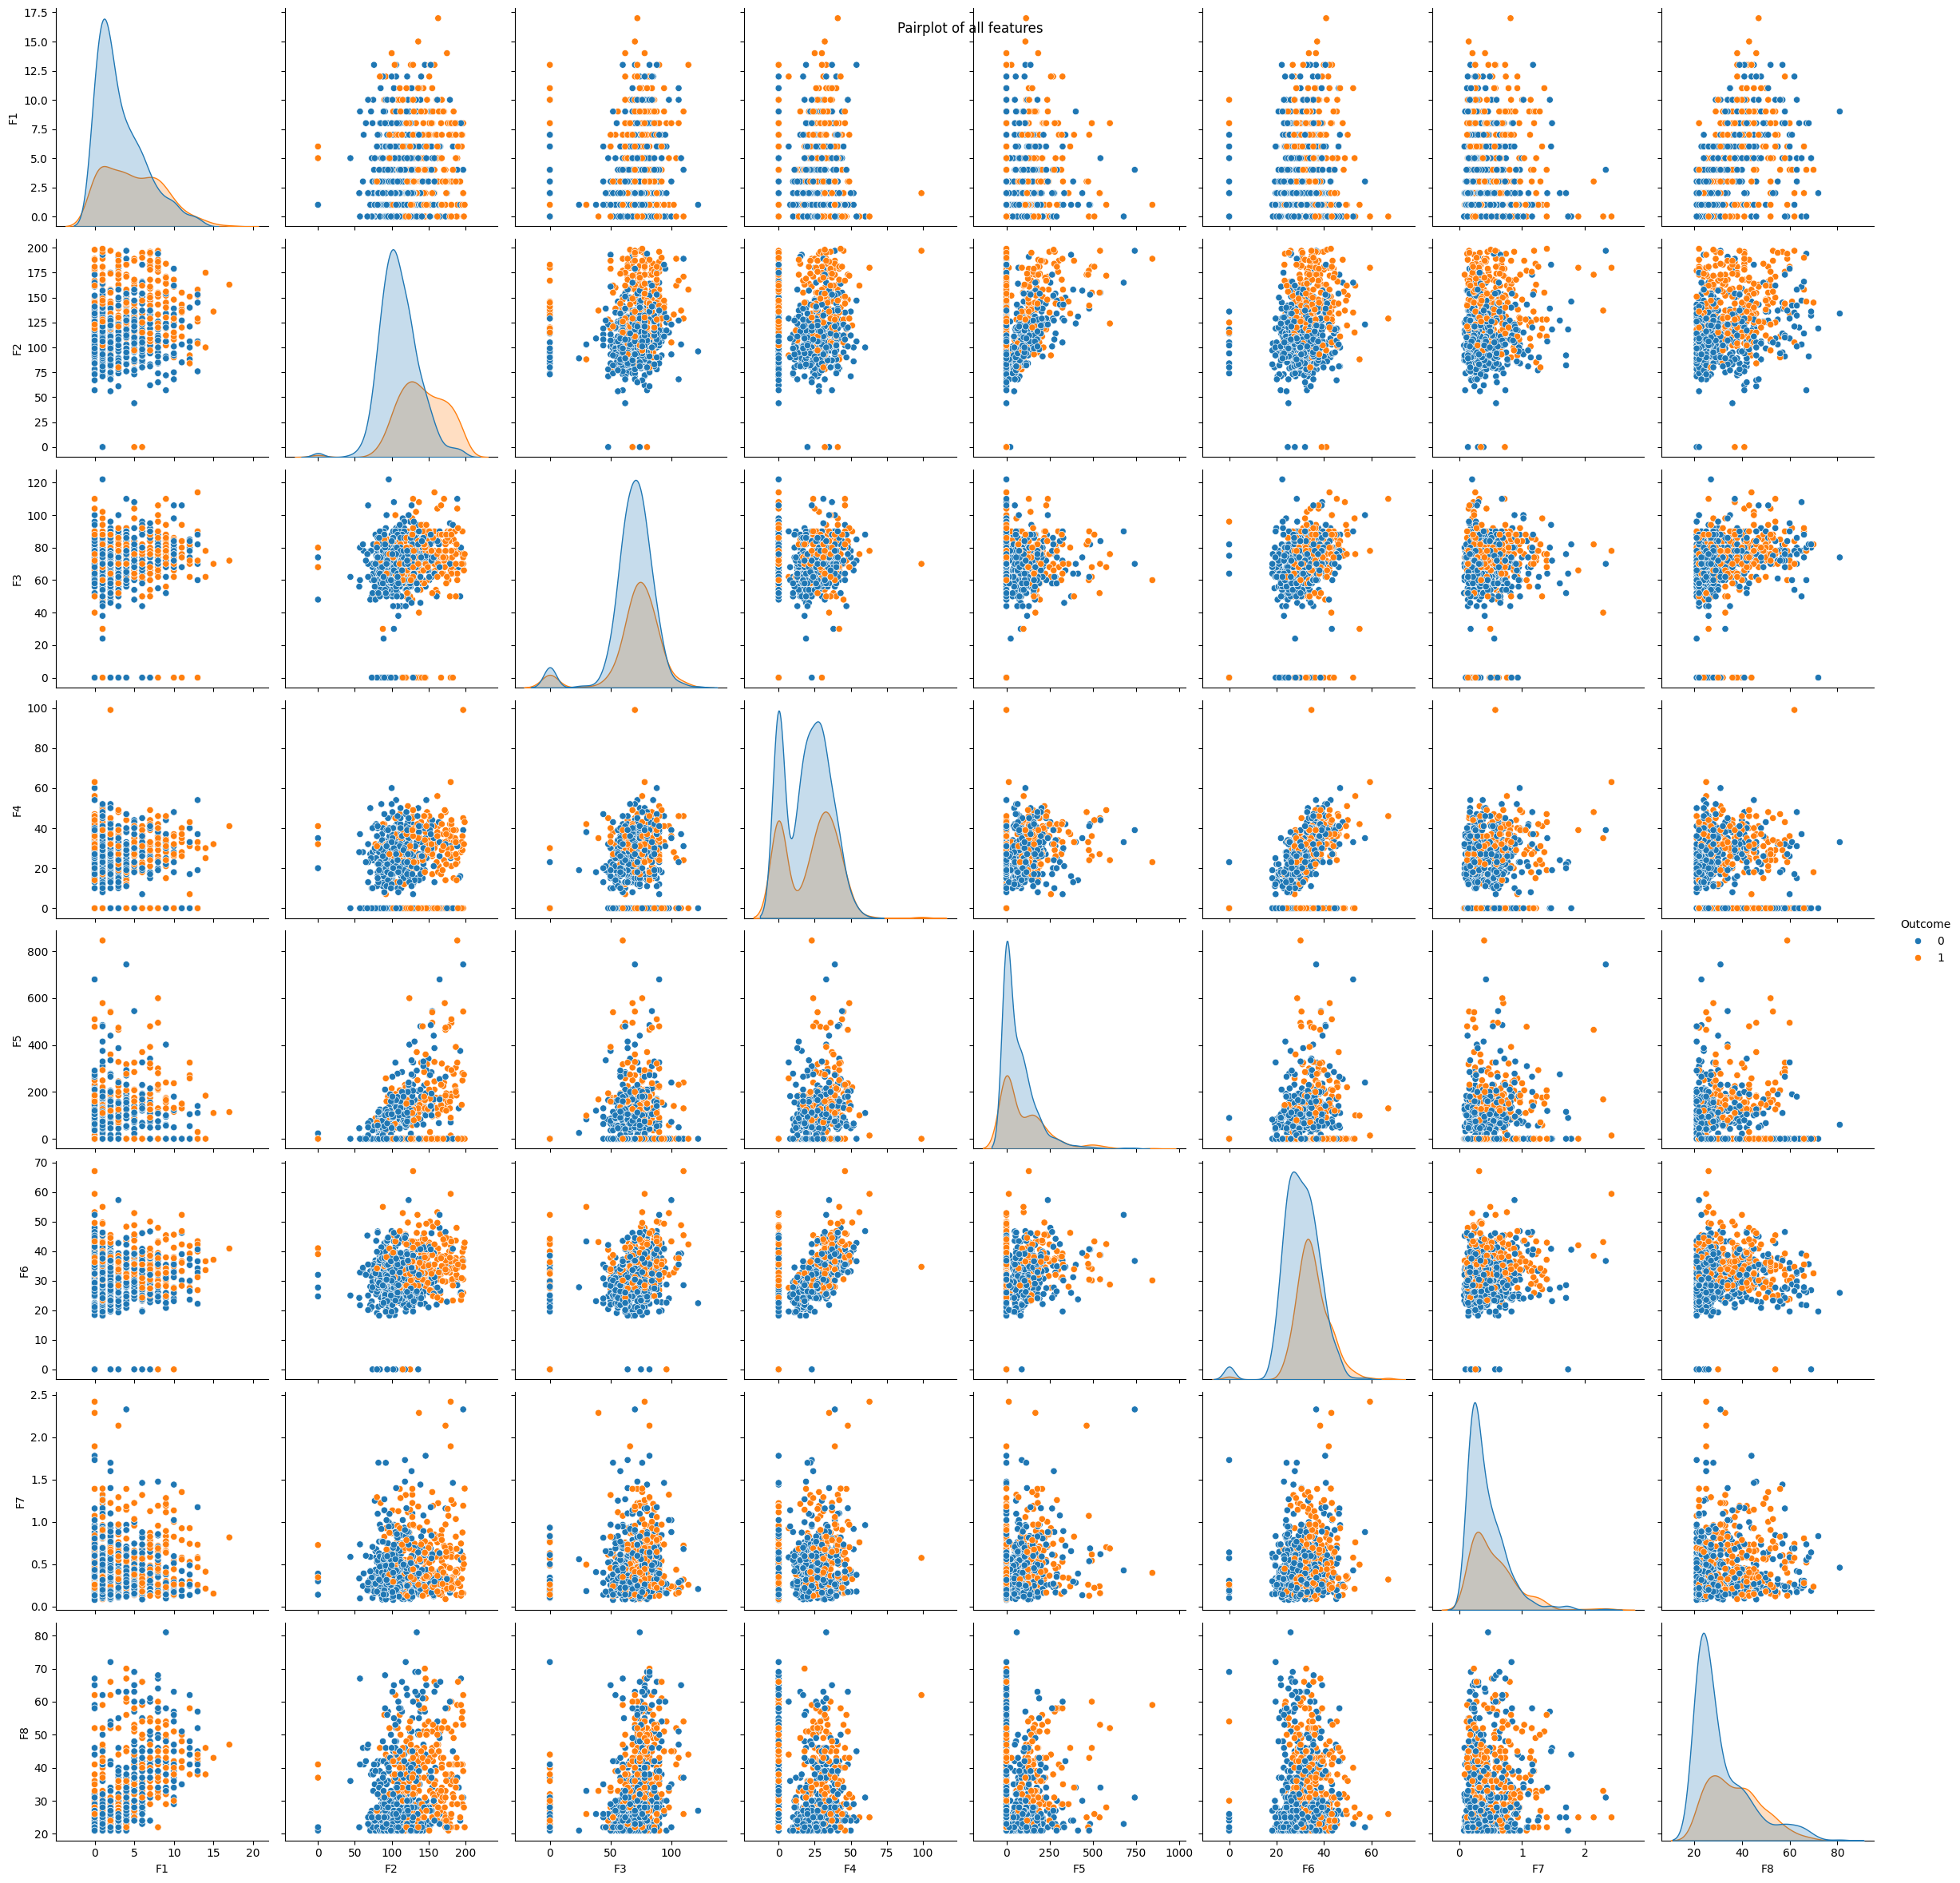

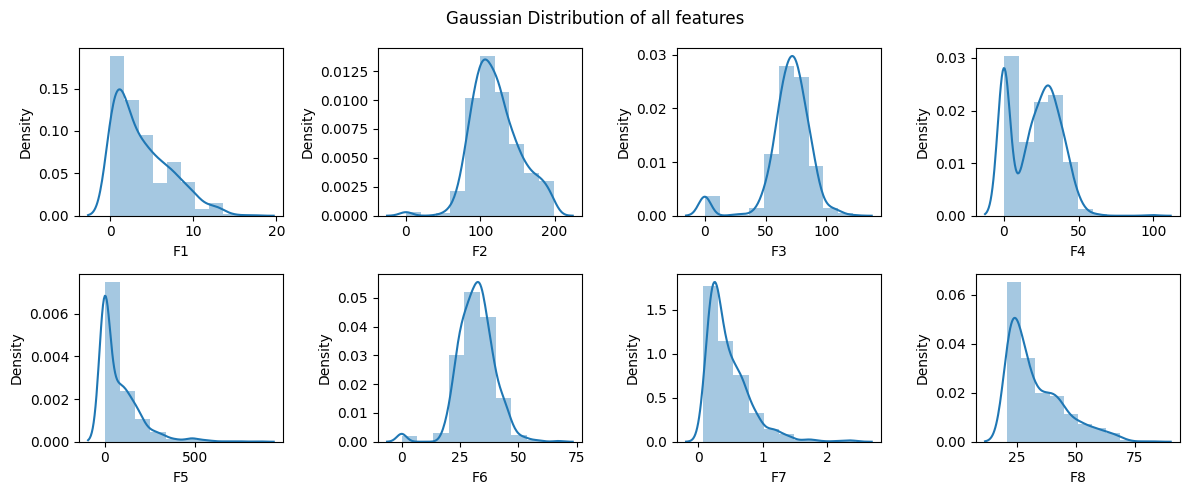

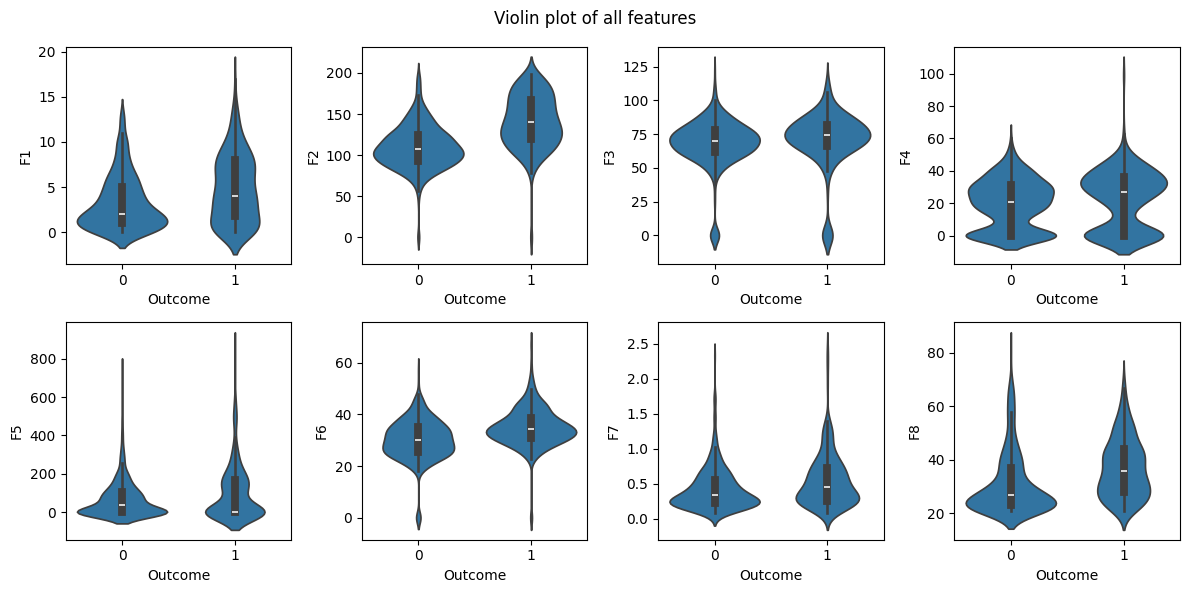

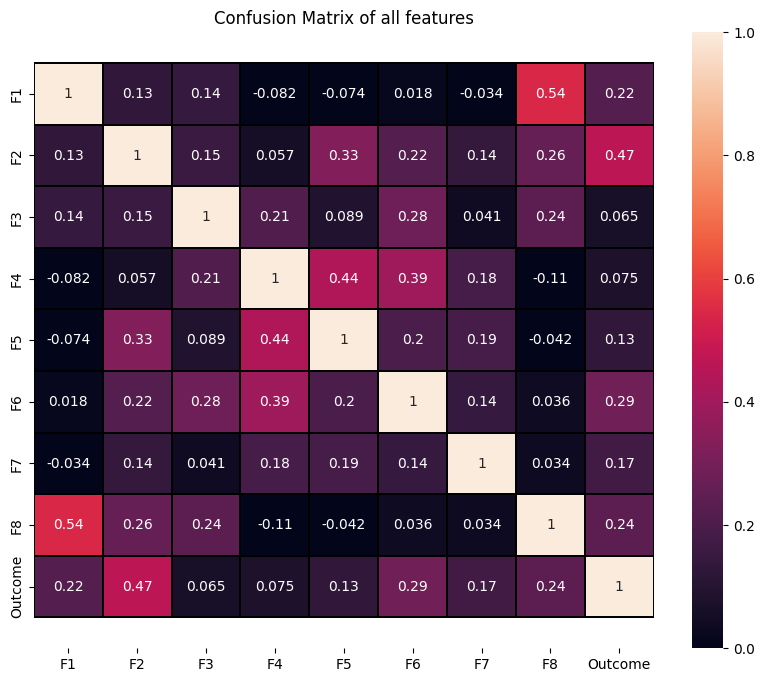

In [ ]:
data_plot (data,
          Pair_plot=True,
          Dist_Plot=True,
          Plot_violinplot=True,
          Plot_confusionMatrix=True,
          box_Gaussian=False)

# Data Preprocessing  

In [ ]:
print(f'Shape Before Process: {data.shape}')

# Outlier rejection using IQR method
data = outlier_Rejection(data, iqr=True)
print(f'Shape After Outlier Removal: {data.shape}')

# Filling missing values for specific columns based on 'Outcome'
for col in ['F2', 'F3', 'F4', 'F5', 'F6']:
    replace_zero(data, col, 'Outcome')
print(f'Shape After Filling Missing Values: {data.shape}')

# Feature selection (PCA, ICA, Correlation, or None)
X_Data, Y_Label = feature_Selector(data, algo='corr', n_feature=6)
print(f'Shape After Feature Selection: {data.shape}')

# Standardization
X_Data = preprocessing.StandardScaler().fit_transform(X_Data)
print(f'Shape After Standardization: {X_Data.shape}')

# Stratified K-Folds cross-validation setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_initializer)


Shape Before Process: (768, 9)
Shape After Outlier Removal: (636, 9)
Shape After Filling Missing Values: (636, 9)
Shape After Feature Selection: (636, 9)
Shape After Standardization: (636, 6)


In [ ]:
print(f'Shape Before Process: {data.shape}')

# Outlier rejection using IQR method
data = outlier_Rejection(data, iqr=True)
print(f'Shape After Outlier Removal: {data.shape}')

# Filling missing values for specific columns based on 'Outcome'
for col in ['F2', 'F3', 'F4', 'F5', 'F6']:
    replace_zero(data, col, 'Outcome')
print(f'Shape After Filling Missing Values: {data.shape}')

# Feature selection (PCA, ICA, Correlation, or None)
X_Data, Y_Label = feature_Selector(data, algo='corr', n_feature=6)
print(f'Shape After Feature Selection: {data.shape}')

# Standardization
X_Data = preprocessing.StandardScaler().fit_transform(X_Data)
print(f'Shape After Standardization: {X_Data.shape}')

# Stratified K-Folds cross-validation setup
kf = StratifiedKFold(n_splits=5, shuffle=False)

Shape Before Process: (636, 9)
Shape After Outlier Removal: (530, 9)
Shape After Filling Missing Values: (530, 9)
Shape After Feature Selection: (530, 9)
Shape After Standardization: (530, 6)


# Processed Data Plot and Presenation

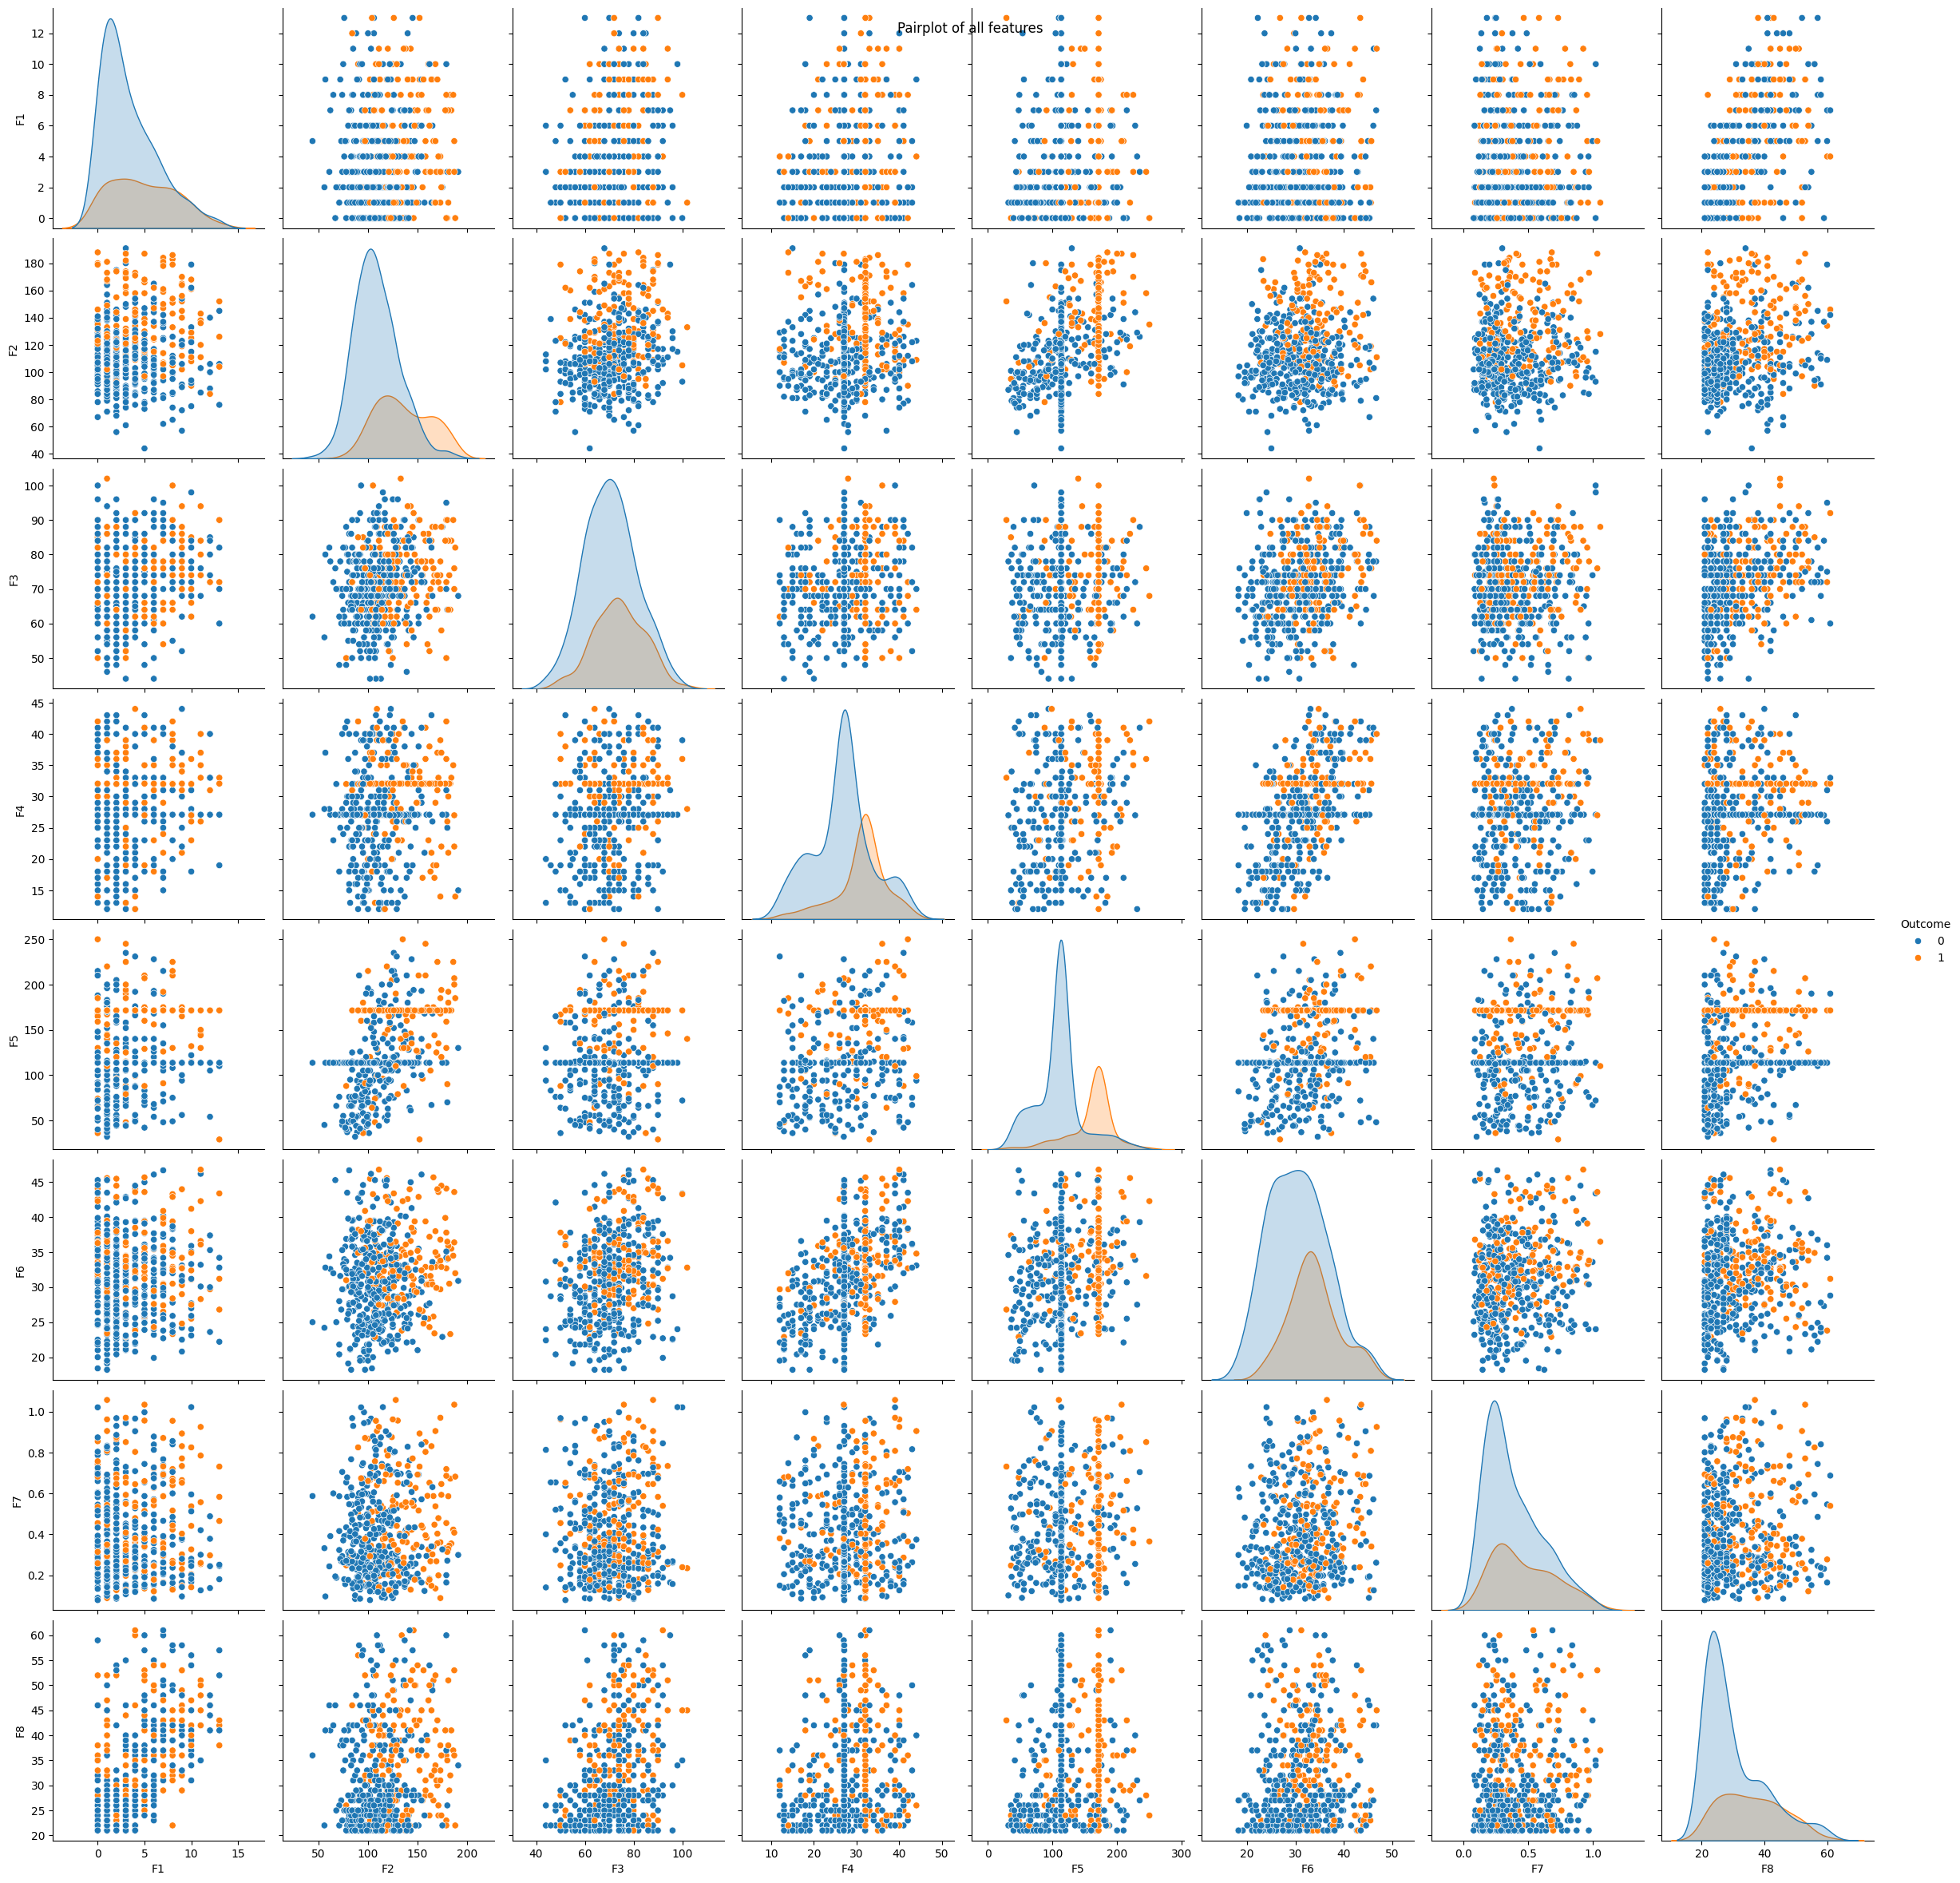

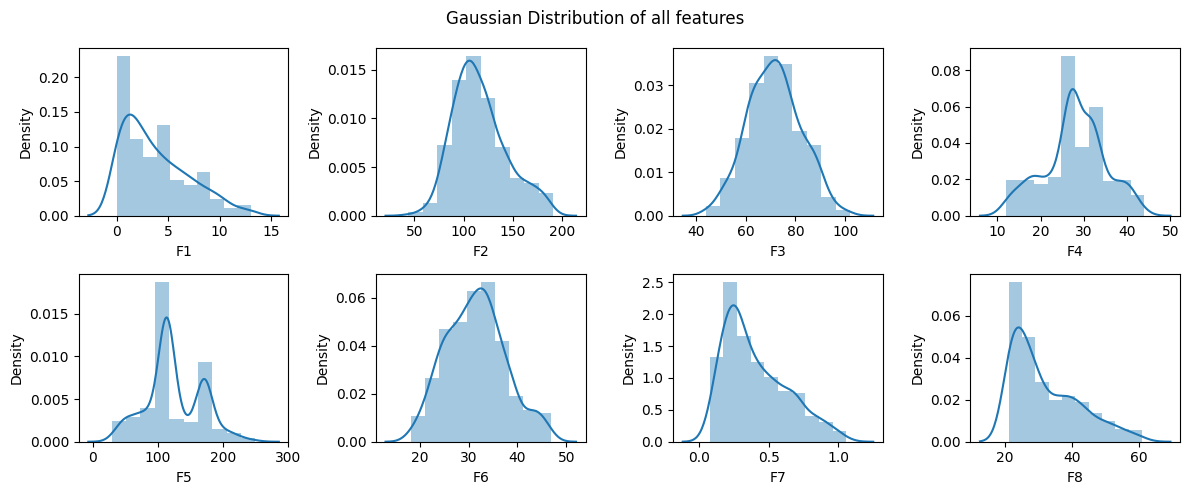

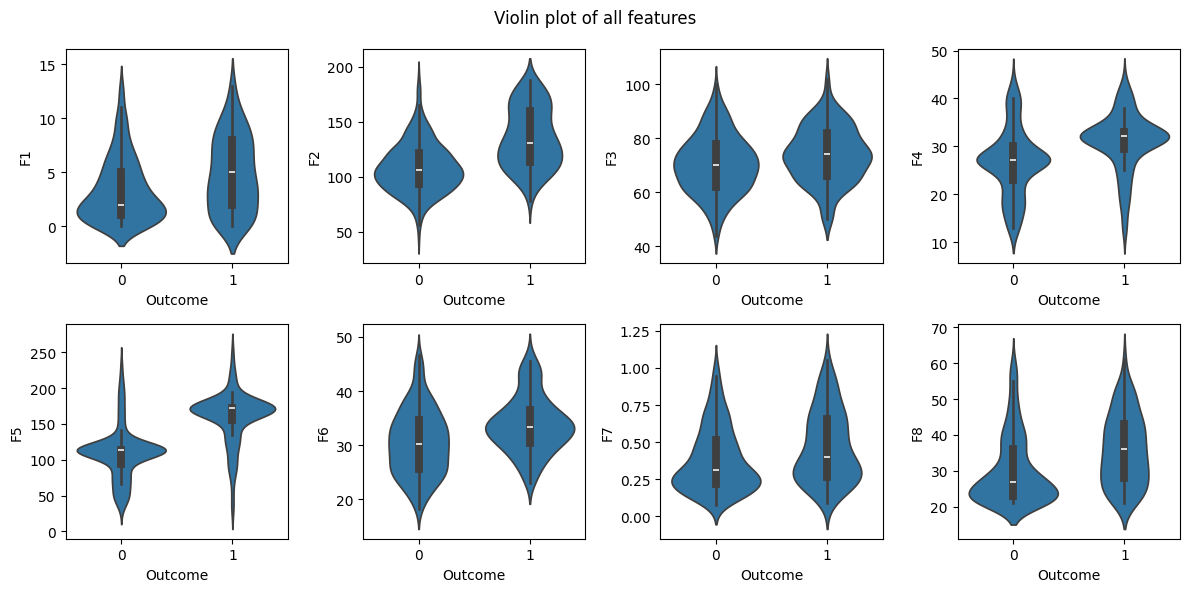

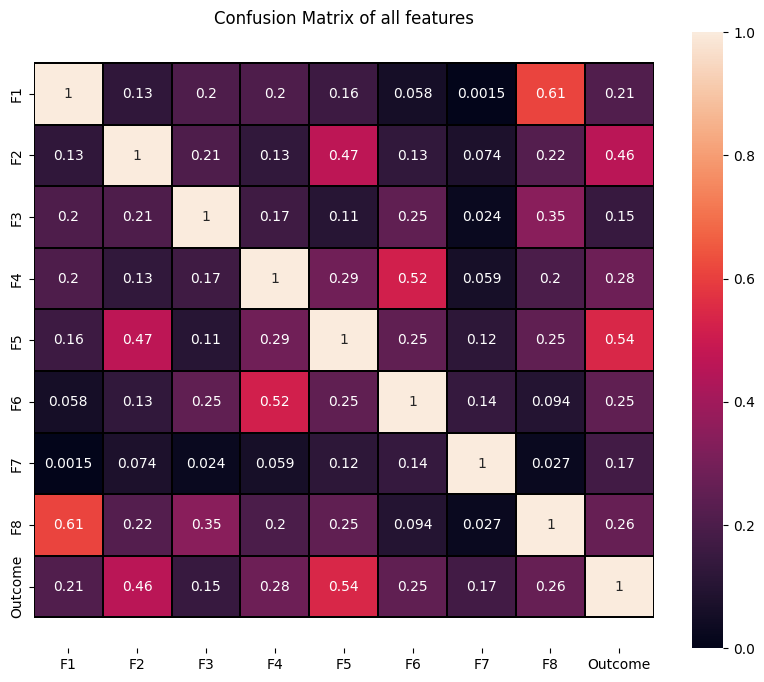

In [ ]:
data_plot (data,
          Pair_plot=True,
          Dist_Plot=True,
          Plot_violinplot=True,
          Plot_confusionMatrix=True,
          box_Gaussian=False)

### Analyzing KNN model

              precision    recall  f1-score   support

           0       0.90      0.96      0.93        75
           1       0.88      0.74      0.81        31

    accuracy                           0.90       106
   macro avg       0.89      0.85      0.87       106
weighted avg       0.90      0.90      0.89       106

AUC: 0.8961290322580645
              precision    recall  f1-score   support

           0       0.89      0.95      0.92        75
           1       0.85      0.71      0.77        31

    accuracy                           0.88       106
   macro avg       0.87      0.83      0.84       106
weighted avg       0.88      0.88      0.87       106

AUC: 0.8636559139784947
              precision    recall  f1-score   support

           0       0.83      0.96      0.89        75
           1       0.84      0.52      0.64        31

    accuracy                           0.83       106
   macro avg       0.83      0.74      0.76       106
weighted avg       0.83   

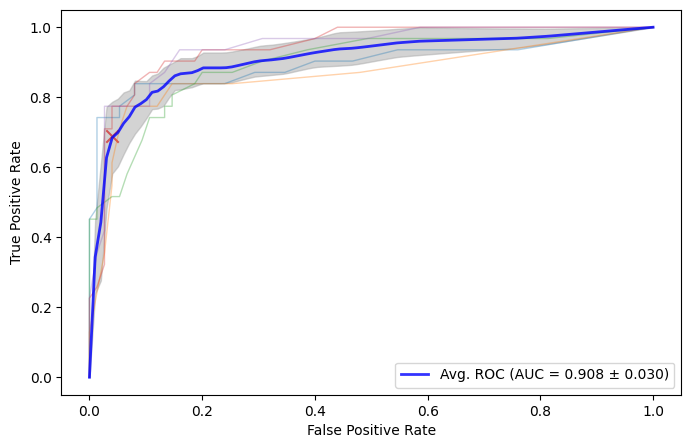

AUC (Avg. ± Std.): 0.908 ± 0.030
Accuracy (Avg. ± Std.): 0.881 ± 0.028
Avg. Confusion Matrix: [[21, 3], [9, 72]]
Total Confusion Matrix: [[107, 15], [48, 360]]


In [ ]:
# Convert Y_Label to a NumPy array if it's not already
Y_Label = np.array(Y_Label)

# Initialize variables to store metrics
metrics_store = {'Accuracy': [], 'TP': [], 'FP': [], 'TN': [], 'FN': [], 'tprs': [], 'aucs': []}
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(8, 5))

# Define KNN hyperparameters
param_grid = [{'n_neighbors': list(range(1, 50, 2)), 'algorithm': ['brute'], 'p': [1, 2]},
              {'n_neighbors': list(range(1, 50, 2)), 'algorithm': ['ball_tree'], 'leaf_size': list(range(5, 55, 5)), 'p': [1, 2]},
              {'n_neighbors': list(range(1, 50, 2)), 'algorithm': ['kd_tree'], 'leaf_size': list(range(5, 55, 5)), 'p': [1, 2]}]

# Stratified K-Fold cross-validation
for i, (train_idx, test_idx) in enumerate(kf.split(X_Data, Y_Label)):
    X_train, X_test = X_Data[train_idx], X_Data[test_idx]
    Y_train, Y_test = Y_Label[train_idx], Y_Label[test_idx]

    # Create and fit KNN model with GridSearchCV
    clf = creat_Model(KNeighborsClassifier(), X_train, Y_train, param_grid, verbose=0)

    # Evaluate the model
    tn, fp, fn, tp, roc_auc, fpr, tpr = metrics(Y_test, clf.predict(X_test), clf.predict_proba(X_test))
    metrics_store['tprs'].append(np.interp(mean_fpr, fpr, tpr))
    metrics_store['tprs'][-1][0] = 0.0
    metrics_store['aucs'].append(roc_auc)
    plot_Current_ROC(fpr, tpr, i, roc_auc)

    # Store fold-wise performance
    metrics_store['TN'].append(tn)
    metrics_store['FP'].append(fp)
    metrics_store['FN'].append(fn)
    metrics_store['TP'].append(tp)
    metrics_store['Accuracy'].append(accuracy_score(Y_test, clf.predict(X_test)))

# Plot and print the average ROC and performance metrics
average_ROC(mean_fpr, metrics_store['tprs'], metrics_store['aucs'], metrics_store['TP'], metrics_store['TN'], metrics_store['FP'], metrics_store['FN'])
average_performance(metrics_store['aucs'], metrics_store['Accuracy'], metrics_store['TP'], metrics_store['TN'], metrics_store['FP'], metrics_store['FN'])


### Analyzing  Decision Trees Classifier

              precision    recall  f1-score   support

           0       0.93      0.87      0.90        75
           1       0.72      0.84      0.78        31

    accuracy                           0.86       106
   macro avg       0.83      0.85      0.84       106
weighted avg       0.87      0.86      0.86       106

AUC: 0.8956989247311827
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        75
           1       0.88      0.71      0.79        31

    accuracy                           0.89       106
   macro avg       0.88      0.83      0.85       106
weighted avg       0.89      0.89      0.88       106

AUC: 0.903010752688172
              precision    recall  f1-score   support

           0       0.84      0.99      0.91        75
           1       0.94      0.55      0.69        31

    accuracy                           0.86       106
   macro avg       0.89      0.77      0.80       106
weighted avg       0.87    

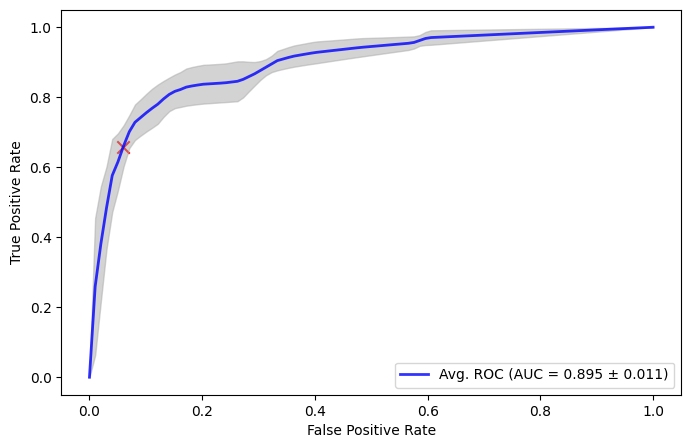

AUC (Avg. ± Std.): 0.895 ± 0.011
Accuracy (Avg. ± Std.): 0.858 ± 0.018
Avg. Confusion Matrix: [[20, 4], [10, 70]]
Total Confusion Matrix: [[102, 22], [53, 353]]


In [ ]:
# Initialize lists to store metrics
Accuracy, FP, TN, FN, TP, tprs, aucs_Tree = [], [], [], [], [], [], []

mean_fpr = np.linspace(0, 1, 100)  # Define the range for False Positive Rate
fig = plt.figure(figsize=(8, 5))    # Create a figure for ROC curves

# Loop through each fold of the cross-validation
for train_index, test_index in kf.split(X_Data, Y_Label):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Label[train_index], Y_Label[test_index]

    # Define the parameters for DecisionTreeClassifier
    tuned_parameters = {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best'],
        'min_samples_split': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_samples_leaf': [1, 2, 3, 4, 5]
    }

    # Create and train the model
    clf = creat_Model(DecisionTreeClassifier(random_state=random_initializer), X_Train, Y_Train, tuned_parameters, verbose=0)

    # Evaluate the model
    tn, fp, fn, tp, roc_auc, fpr, tpr = metrics(Y_Test, clf.predict(X_Test), clf.predict_proba(X_Test))

    # Store metrics
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_Tree.append(roc_auc)
    Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)

# Plot average ROC curve
average_ROC(mean_fpr, tprs, aucs_Tree, TP, TN, FP, FN)
# Print average performance metrics
average_performance(aucs_Tree, Accuracy, TP, TN, FP, FN)


### Analyzing Random Forest Classifier

              precision    recall  f1-score   support

           0       0.92      0.88      0.90        75
           1       0.74      0.81      0.77        31

    accuracy                           0.86       106
   macro avg       0.83      0.84      0.83       106
weighted avg       0.86      0.86      0.86       106

AUC: 0.9137634408602151
              precision    recall  f1-score   support

           0       0.90      0.93      0.92        75
           1       0.82      0.74      0.78        31

    accuracy                           0.88       106
   macro avg       0.86      0.84      0.85       106
weighted avg       0.88      0.88      0.88       106

AUC: 0.9049462365591397
              precision    recall  f1-score   support

           0       0.87      0.95      0.90        75
           1       0.83      0.65      0.73        31

    accuracy                           0.86       106
   macro avg       0.85      0.80      0.82       106
weighted avg       0.86   

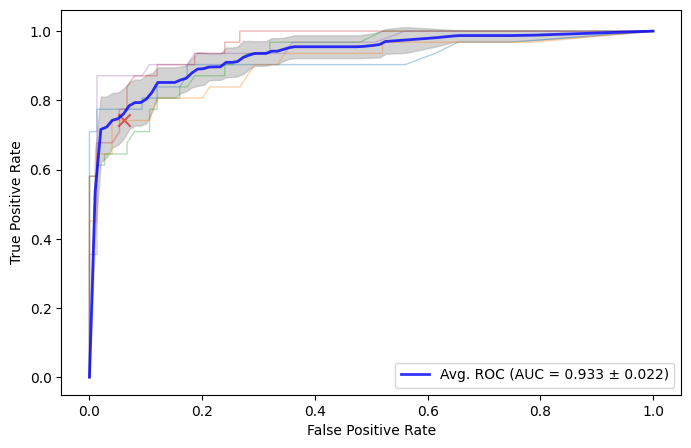

AUC (Avg. ± Std.): 0.933 ± 0.022
Accuracy (Avg. ± Std.): 0.881 ± 0.028
Avg. Confusion Matrix: [[23, 4], [8, 70]]
Total Confusion Matrix: [[115, 23], [40, 352]]


In [ ]:
# Initialize lists to store metrics
Accuracy, FP, TN, FN, TP, tprs, aucs_Forest = [], [], [], [], [], [], []

mean_fpr = np.linspace(0, 1, 100)  # Define the range for False Positive Rate
fig = plt.figure(figsize=(8, 5))    # Create a figure for ROC curves

# Loop through each fold of the cross-validation
for train_index, test_index in kf.split(X_Data, Y_Label):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Label[train_index], Y_Label[test_index]

    # Define parameters for RandomForestClassifier
    tuned_parameters = {'criterion': ['gini', 'entropy']}

    # Create and train the RandomForest model
    clf = creat_Model(RandomForestClassifier(random_state=random_initializer), X_Train, Y_Train, tuned_parameters, verbose=0)

    # Evaluate the model
    tn, fp, fn, tp, roc_auc, fpr, tpr = metrics(Y_Test, clf.predict(X_Test), clf.predict_proba(X_Test))

    # Store metrics and plot ROC curve
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_Forest.append(roc_auc)
    plot_Current_ROC(fpr, tpr, iterator, roc_auc)

    Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)

    iterator += 1

# Plot average ROC curve
average_ROC(mean_fpr, tprs, aucs_Forest, TP, TN, FP, FN)
# Print average performance metrics
average_performance(aucs_Forest, Accuracy, TP, TN, FP, FN)


### Analyzing AdaBoost Classifier

              precision    recall  f1-score   support

           0       0.92      0.95      0.93        75
           1       0.86      0.81      0.83        31

    accuracy                           0.91       106
   macro avg       0.89      0.88      0.88       106
weighted avg       0.90      0.91      0.90       106

AUC: 0.9432258064516128
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        75
           1       0.79      0.71      0.75        31

    accuracy                           0.86       106
   macro avg       0.84      0.81      0.82       106
weighted avg       0.86      0.86      0.86       106

AUC: 0.8886021505376344
              precision    recall  f1-score   support

           0       0.87      0.95      0.90        75
           1       0.83      0.65      0.73        31

    accuracy                           0.86       106
   macro avg       0.85      0.80      0.82       106
weighted avg       0.86   

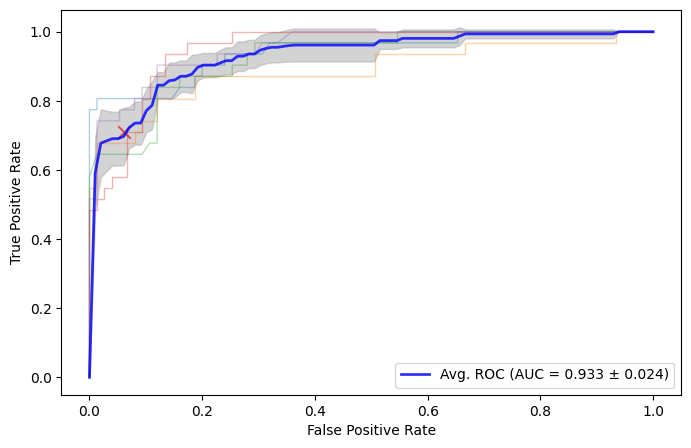

AUC (Avg. ± Std.): 0.933 ± 0.024
Accuracy (Avg. ± Std.): 0.872 ± 0.025
Avg. Confusion Matrix: [[22, 4], [9, 70]]
Total Confusion Matrix: [[110, 23], [45, 352]]


In [ ]:
# Initialize lists to store metrics
Accuracy, FP, TN, FN, TP, tprs, aucs_aBoost = [], [], [], [], [], [], []

mean_fpr = np.linspace(0, 1, 100)  # Define range for False Positive Rate
fig = plt.figure(figsize=(8, 5))    # Create a figure for ROC curves

# Loop through each fold of the cross-validation
for train_index, test_index in kf.split(X_Data, Y_Label):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Label[train_index], Y_Label[test_index]

    # Define AdaBoost parameters
    tuned_parameters = {
        'algorithm': ['SAMME', 'SAMME.R'],
        'learning_rate': [0.1, 0.5, 1.0],
        'n_estimators': [10, 50, 100, 200]
    }

    # Create and train the AdaBoost model
    clf = creat_Model(
        classifier=AdaBoostClassifier(random_state=random_initializer),
        X_Train=X_Train,
        Y_Train=Y_Train,
        tuned_parameters=tuned_parameters,
        verbose=0
    )

    # Evaluate the model
    tn, fp, fn, tp, roc_auc, fpr, tpr = metrics(
        y_true=Y_Test,
        y_pred=clf.predict(X_Test),
        probas_=clf.predict_proba(X_Test)
    )

    # Store metrics and plot ROC curve
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_aBoost.append(roc_auc)
    plot_Current_ROC(fpr, tpr, iterator, roc_auc)

    Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)

    iterator += 1

# Plot average ROC curve and print average performance metrics
average_ROC(mean_fpr, tprs, aucs_aBoost, TP, TN, FP, FN)
average_performance(aucs_aBoost, Accuracy, TP, TN, FP, FN)


### Analyzing Naive Bayes Model

              precision    recall  f1-score   support

           0       0.90      0.92      0.91        75
           1       0.79      0.74      0.77        31

    accuracy                           0.87       106
   macro avg       0.84      0.83      0.84       106
weighted avg       0.87      0.87      0.87       106

AUC: 0.8739784946236558
              precision    recall  f1-score   support

           0       0.86      0.83      0.84        75
           1       0.62      0.68      0.65        31

    accuracy                           0.78       106
   macro avg       0.74      0.75      0.74       106
weighted avg       0.79      0.78      0.79       106

AUC: 0.8486021505376344
              precision    recall  f1-score   support

           0       0.86      0.87      0.86        75
           1       0.67      0.65      0.66        31

    accuracy                           0.80       106
   macro avg       0.76      0.76      0.76       106
weighted avg       0.80   

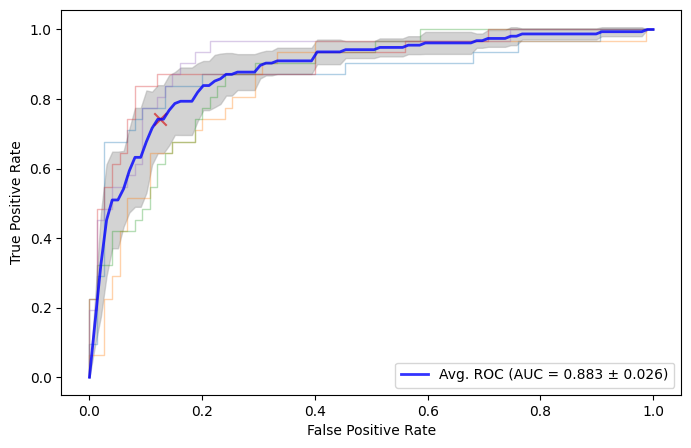

AUC (Avg. ± Std.): 0.883 ± 0.026
Accuracy (Avg. ± Std.): 0.836 ± 0.037
Avg. Confusion Matrix: [[23, 9], [8, 65]]
Total Confusion Matrix: [[115, 47], [40, 328]]


In [ ]:
# Initialize lists for metrics
Accuracy, FP, TN, FN, TP, tprs, aucs_NB = [], [], [], [], [], [], []

mean_fpr = np.linspace(0, 1, 100)  # Define range for False Positive Rate
fig = plt.figure(figsize=(8, 5))    # Create a figure for ROC curves

# Loop through each fold of cross-validation
for train_index, test_index in kf.split(X_Data, Y_Label):
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]
    Y_Train, Y_Test = Y_Label[train_index], Y_Label[test_index]

    # Define Naive Bayes parameters
    tuned_parameters = [{'var_smoothing': np.logspace(-12, -1, 12)}]

    # Create and train the Naive Bayes model
    clf = creat_Model(
        classifier=GaussianNB(),
        X_Train=X_Train,
        Y_Train=Y_Train,
        tuned_parameters=tuned_parameters,
        verbose=0
    )

    # Evaluate the model
    tn, fp, fn, tp, roc_auc, fpr, tpr = metrics(
        y_true=Y_Test,
        y_pred=clf.predict(X_Test),
        probas_=clf.predict_proba(X_Test)
    )

    # Store metrics and plot ROC curve
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_NB.append(roc_auc)
    plot_Current_ROC(fpr, tpr, iterator, roc_auc)

    Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)

    iterator += 1

# Plot average ROC curve and print average performance metrics
average_ROC(mean_fpr, tprs, aucs_NB, TP, TN, FP, FN)
average_performance(aucs_NB, Accuracy, TP, TN, FP, FN)


### Analyzing XGBoost Model

              precision    recall  f1-score   support

           0       0.92      0.91      0.91        75
           1       0.78      0.81      0.79        31

    accuracy                           0.88       106
   macro avg       0.85      0.86      0.85       106
weighted avg       0.88      0.88      0.88       106

AUC: 0.9412903225806452
              precision    recall  f1-score   support

           0       0.90      0.93      0.92        75
           1       0.82      0.74      0.78        31

    accuracy                           0.88       106
   macro avg       0.86      0.84      0.85       106
weighted avg       0.88      0.88      0.88       106

AUC: 0.9208602150537634
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        75
           1       0.83      0.77      0.80        31

    accuracy                           0.89       106
   macro avg       0.87      0.85      0.86       106
weighted avg       0.89   

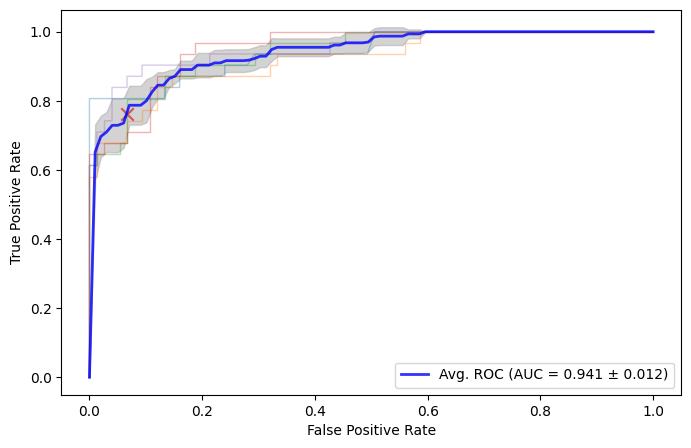

AUC (Avg. ± Std.): 0.941 ± 0.012
Accuracy (Avg. ± Std.): 0.883 ± 0.018
Avg. Confusion Matrix: [[23, 5], [7, 70]]
Total Confusion Matrix: [[118, 25], [37, 350]]
Sensitivity (Avg. +/- Std.) is  0.761 +/- 0.048
Specificity (Avg. +/- Std.) is  0.933 +/- 0.017
Precision (Avg. +/- Std.) is  0.826 +/- 0.037
FOR (Avg. +/- Std.) is  0.095 +/- 0.017
DOR (Avg. +/- Std.) is  51.625 +/- 24.903


In [ ]:
Accuracy = []                                                                # for store the value of accuracy
FP = []                                                                      # for store False Positive
TN = []                                                                      # for True Negative
FN = []                                                                      # for False Negative
TP = []                                                                      # for True Positive
tprs = []                                                                    # for true positive rates
aucs_xboost = []                                                                # for store the values of auc
sn = []                                                                      # for sensitivity
sp = []                                                                      # for specificity
pr = []                                                                      # for precision
FOR = []                                                                     # for False omission rate
DOR = []                                                                     # for Diagnostic odds ratio (DOR)
iterator=0
mean_fpr = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(8, 5))


for train_index, test_index in kf.split(X_Data,Y_Label):                     # split into train and test
#   print("TRAIN:", train_index, "TEST:", test_index)
    X_Train, X_Test = X_Data[train_index], X_Data[test_index]                #train data and label
    Y_Train, Y_Test = Y_Label[train_index], Y_Label[test_index]              #test data and label

    #####################################
    ## define the parameters
    ######################################
    tuned_parameters = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.5, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

    clf = creat_Model (classifier = xgb.XGBClassifier(objective = "binary:logistic", eval_metric = 'error', random_state=random_initializer),
                      X_Train = X_Train,                                        # create model using XGB classifier
                      Y_Train = Y_Train,
                      tuned_parameters = tuned_parameters,
                      verbose=0)
    tn, fp, fn, tp, roc_auc, fpr, tpr = metrics (y_true = Y_Test,               #evaluate the model parameters
                                                y_pred = clf.predict(X_Test),
                                                probas_ = clf.predict_proba(X_Test))
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs_xboost.append(roc_auc)
    plot_Current_ROC(fpr,tpr,iterator,roc_auc)                                  #plot the roc of current fold
    iterator += 1
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)
    Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
    sn.append(tp/(tp+fn))
    sp.append(tn/(fp+tn))
    pr.append(tp/(tp+fp))
    FOR.append(fn/(tn+fn))
    DOR.append((tp*tn)/(fp*fn))

average_ROC(mean_fpr,tprs,aucs_xboost,TP,TN,FP,FN)                              #plot average roc curve
average_performance(aucs_xboost,Accuracy,TP,TN,FP,FN)                           #print the average performance of the model

#####################################################################
#    print the sensitivity,specificity,precision,for,dor of model
#####################################################################
print("Sensitivity (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(sn),np.std(sn)))
print("Specificity (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(sp),np.std(sp)))
print("Precision (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(pr),np.std(pr)))
print("FOR (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(FOR),np.std(FOR)))
print("DOR (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(DOR),np.std(DOR)))